# Detector for staying on path, and for routing to a specific point

In [1]:
import rospy 
import tf
import tf2_ros
from sensor_msgs.msg import Image, PointCloud2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# register node
rospy.init_node('mapper', anonymous=True)


from mapping import mapper

reload(mapper)
livemap = mapper.Mapper()

## Here's the camera image

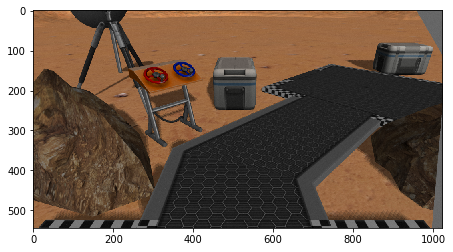

In [2]:
livemap.update()

plt.figure(figsize=(8,4))
plt.imshow(livemap.im);

# We don't have valid depth measurements for a lot of the points

Filling in "missing" values with greenscreen:

In [3]:
valid = ~np.isnan(livemap.points[:,:,0])
im_valid = np.array(livemap.im)
im_valid[~valid] = [0, 255, 0]
plt.figure(figsize=(8,4))
plt.imshow(im_valid);

# We can plot the world position location for the points we do have

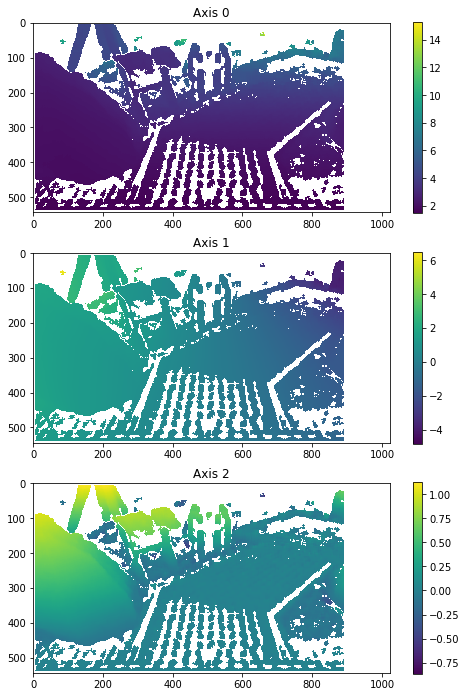

In [4]:
plt.figure(figsize=(8,12))
for axis in (0,1,2):
    plt.subplot(3,1,axis+1)
    plt.imshow(livemap.points[:,:,axis])
    plt.title("Axis %d" % axis)
    plt.colorbar();

## Using the height (z-axis) info it is pretty easy to find "safe" walking area

Here's (e.g.) a simple way to get the boundaries of the main path.

We can also identify points which we are certain we should NOT step on:

In [5]:
def find_walkway(im, points):
    valid = ~np.isnan(points[:,:,0])
    points = points[valid]
    im = im[valid]
    assert points.ndim == 2
    is_ground = (points[:,2] > 0.0) * (points[:,2] < 0.1)
    is_flat_color = (im[:,0] == im[:,1]) * (im[:,1] == im[:,2])
    return is_ground * is_flat_color

def find_unsafe(im, points):
    valid = ~np.isnan(points[:,:,0])
    points = points[valid]
    im = im[valid]
    assert points.ndim == 2
    is_ground =  (points[:,2] < 0.1)
    is_red = im[:,0] - im[:,1:].mean(-1) > 40
    return is_ground*is_red


walkway = np.zeros(livemap.im.shape)
valid = ~np.isnan(livemap.points[:,:,0])
walkway[:,:,1][valid] = 1.0*find_walkway(livemap.im, livemap.points)
walkway[:,:,0][valid] = 1.0*find_unsafe(livemap.im, livemap.points)

plt.figure(figsize=(8,4))
plt.imshow(walkway);

# Mapping

We can use the `(x, y)` coordinates to build a map dynamically. We're going to grid the entire world at 10cm.

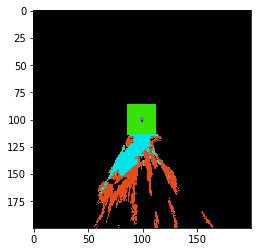

In [6]:
plt.imshow(livemap.render(), aspect=1.0)

## Here's how we can check if a particular straight-line path is safe.

In [9]:
def is_straight_line_safe(start, end, plot=False):
    mix = np.linspace(0,1,20)
    robot_width = 0.25
    #start = np.random.rand(10,2)*robot_width + start[:2] - 0.5*robot_width
    #end = np.random.rand(10,2)*robot_width + np.array([end]) - 0.5*robot_width
    end = np.array(end)
    start = start[:2]
    traj = (start[:,None]*(1-mix) + end[:,None]*(mix))
    traj = traj[:,:,None] + np.random.rand(2,len(mix),5)*robot_width - 0.5*robot_width
    traj = traj.reshape((2,-1))
    xt, yt = livemap.point_to_bin(traj[0], traj[1])
    res = (livemap.DETECT[xt, yt])
    if plot:
        IMAGE = livemap.render(crop=False)
        IMAGE[xt, yt, :] = (1,1,0)
        plt.imshow(IMAGE[100:300,200:500])
    return np.all(res)

def is_destination_safe(end):
    return livemap.DETECT[livemap.point_to_bin(*end)]

def get_path(start, looking_at, target):
    start = np.array(start)[:2]
    v1 = np.array(looking_at)[:2] - start
    v2 = np.array(target) - start
    #angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)))
    angle = np.rad2deg(np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0]))
    direction = 'r' if angle < 0 else 'l'
    if angle >= 90:
        angle *= 0.5
        turn = "%s%0.2f" % (direction, np.abs(angle))
        turn = turn+","+turn
    else:
        turn = "%s%0.2f" % (direction, np.abs(angle))
    dist = np.linalg.norm(v2)
    return "%s,%0.3f" % (turn, dist)

pos, direction = livemap.robot_current_location()
target = [1.0, -0.25]

print is_destination_safe(target)
print livemap.point_to_bin(*target)
print livemap.DETECT.shape
print is_straight_line_safe(pos, target)

path = get_path(pos, direction, target)

True
(array(226), array(561))
(1213, 960)
True


### Before running the following line, start the walk listener:

in the `finals` directory, run `python -m mapping.walk_listener`

In [10]:
from std_msgs.msg import String
walker = rospy.Publisher('/humanz/walk', String, queue_size=1)

In [11]:
print "publishing path", path
walker.publish(path)

publishing path r15.50,0.994


In [17]:
livemap.update()
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(livemap.im)
plt.subplot(122)
plt.imshow(livemap.render());

In [19]:
print livemap.robot_current_location()[0][:2]

[ 0.99719162 -0.25205214]


In [20]:
pos, direction = livemap.robot_current_location()
target = [3.0, -0.5]

print is_destination_safe(target)
print is_straight_line_safe(pos, target)

True
True


In [21]:
path = get_path(pos, direction, target)
if is_straight_line_safe(pos, target):
    print "straight line looks safe, walking route", path
    walker.publish(path)

straight line looks safe, walking route l8.60,2.018


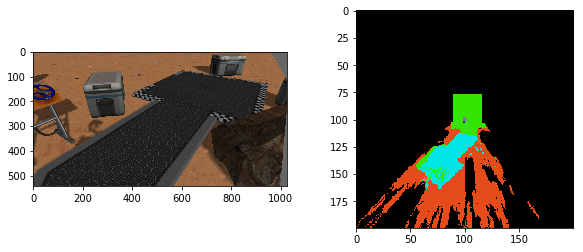

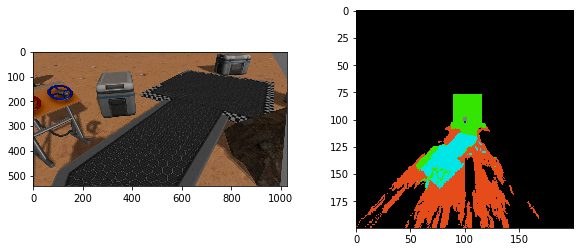

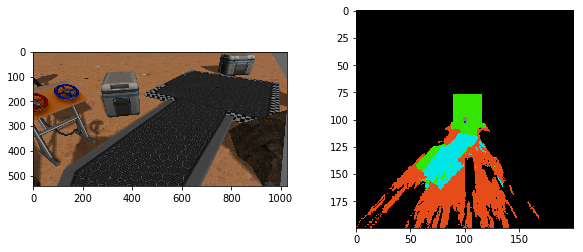

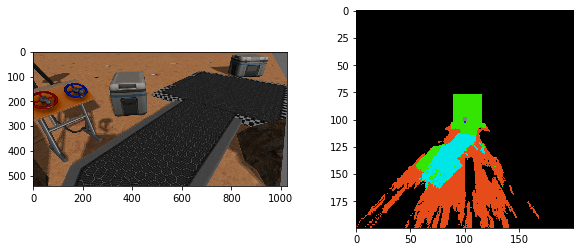

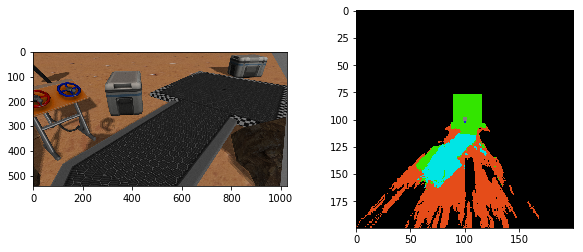

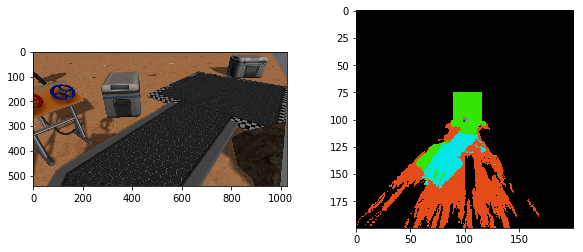

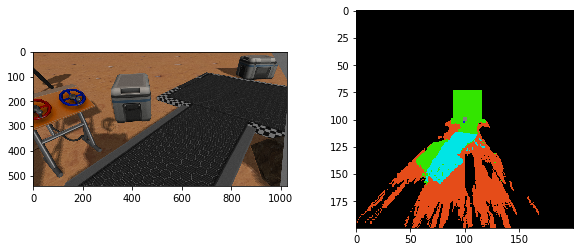

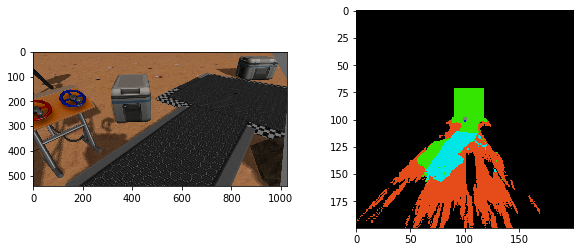

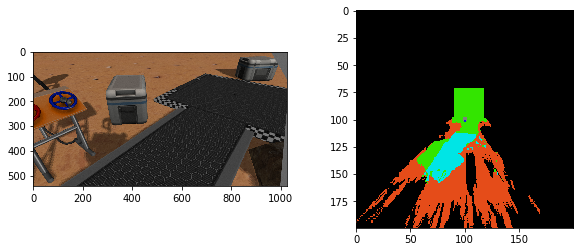

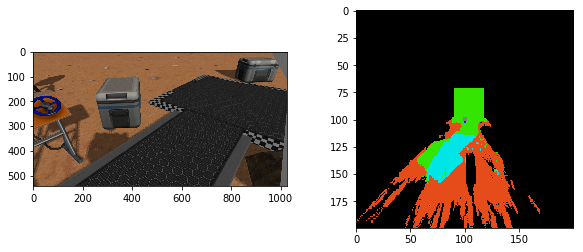

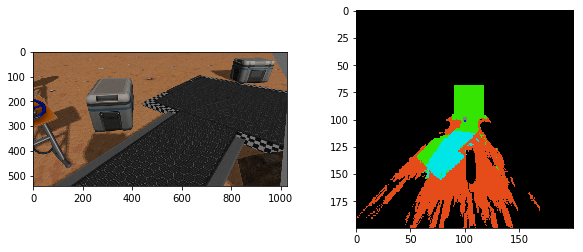

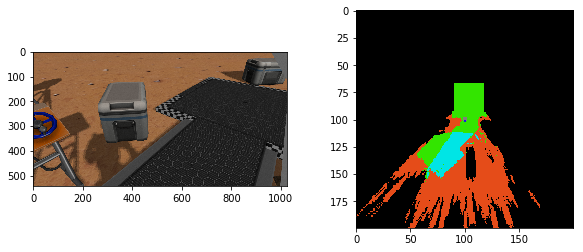

In [22]:
import time 

for i in xrange(20):
    time.sleep(5)
    livemap.update()
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.imshow(livemap.im)
    plt.subplot(122)
    plt.imshow(livemap.render());
    plt.show()

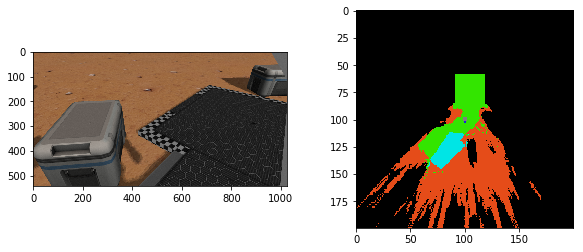

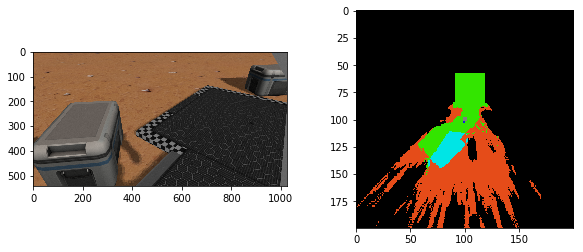

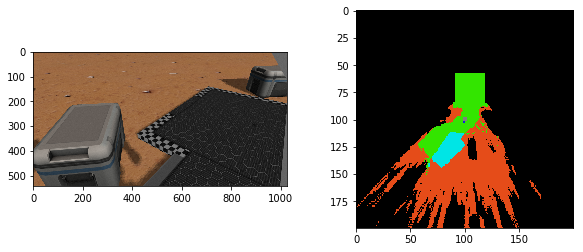

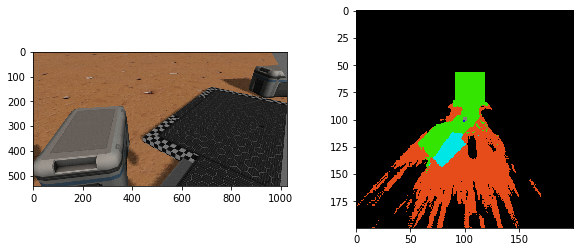

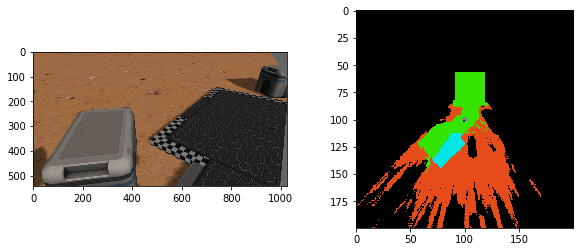

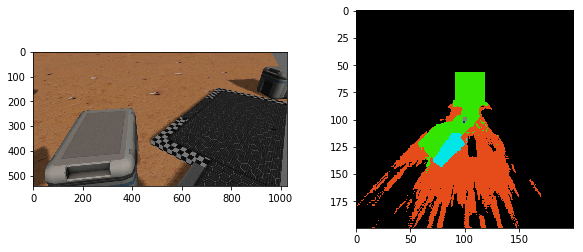

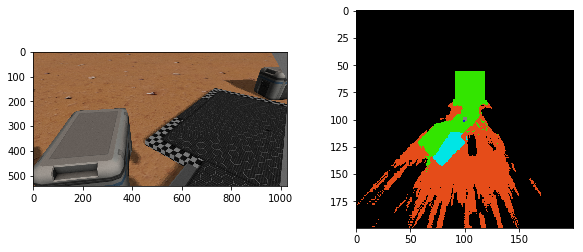

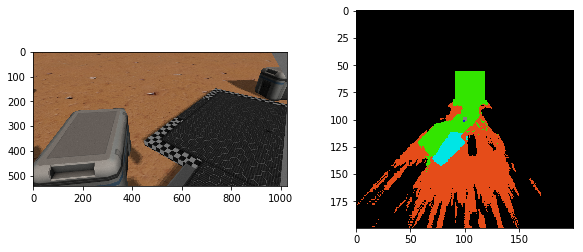

In [23]:
for i in xrange(10):
    livemap.update()
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.imshow(livemap.im)
    plt.subplot(122)
    plt.imshow(livemap.render());
    plt.show()
    time.sleep(5)

## Next is to do more serious pathfinding

If a straight line is not safe, propose some alternative